<a href="https://colab.research.google.com/github/paoandreachv/Practica/blob/Iceland/Islandia_Prueba_Datos_Completos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyGMTSAR Time series: Reykjavik, Iceland

Breve introducción blabla


# Instalación de Google Colab

Instalaremos PyGMTSAR y los binarios requeridos de GMTSAR para que este software funcione (incluyendo SNAPHU, el cual es una herramienta complementaria usada específicamente para desenvolver fases interferométricas en imágenes de radar).


In [21]:
# Importaremos las librerías necesarias y se verifica si el código se está
# ejecutando en Google Colab.

import platform, sys, os

if 'google.colab' in sys.modules:
# Instalación de la librería PyGMTSAR
  !{sys.executable} -m pip install -q pygmtsar
  # Instalación de dependencias binarias
  import importlib.resources as resources
  with resources.as_file(resources.files('pygmtsar.data') / 'google_colab.sh') as google_colab_script_filename:
      !sh {google_colab_script_filename}
  # Vamos a permitir la visualización interactiva de datos
  from google.colab import output
  output.enable_custom_widget_manager()
  # Se inicializa un espacio de memoria (buffer) que simula una pantalla, permitiendo realizar operaciones gráficas 3D
  import xvfbwrapper
  display = xvfbwrapper.Xvfb(width=800, height=600)
  display.start()

# Configuramos la variable de entorno PATH para que incluya la ruta de instalación de GMTSAR
PATH = os.environ['PATH']
if PATH.find('GMTSAR') == -1:
    PATH = os.environ['PATH'] + ':/usr/local/GMTSAR/bin/'
    %env PATH {PATH}

# Se imprime la versión de PyGMTSAR que se ha instalado.
from pygmtsar import __version__
__version__


'2024.8.30.post5'

# Cargar y configurar módulos de Python

In [22]:
# Se utiliza para trabajar con datos multidimensionales, como los datos de SAR.
import xarray as xr

# Permite trabajar con matrices y operaciones numéricas.
import numpy as np

# Se utiliza para manipular y analizar datos tabulares.
import pandas as pd

# Se utiliza para trabajar datos geoespaciales.
import geopandas as gpd

# Se usa comúnmente para almacenar y transferir datos.
import json

# Dask es ideal para trabajos que no caben en la memoria de un solo equipo.
from dask.distributed import Client

# Procesa grandes conjuntos de datos
import dask

Esta parte del código se encarga de importar y configurar las librerías necesarias para la visualización de los datos. Se divide en dos partes importantes:

- Módulos de gráficos


In [23]:
# define Pandas display settings/configura las opciones de visualización de Pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

In [24]:
# Módulos de gráficos

# Importa la librería de PyVista (pv), que se usa para la
# visualización 3D interactiva.
import pyvista as pv

# Configura el tema de PyVista a "document", que generalmente
# usa un fondo blanco para las gráficas.
pv.set_plot_theme("document")

# Importa la librería Panel, que se usa para crear paneles interactivos
# y visualizaciones web.
import panel

# Habilita la comunicación entre Panel y los widgets de Jupyter.
panel.extension(comms='ipywidgets')

# Habilita el soporte para visualizaciones VTK (Visualization Toolkit)
# en Panel, lo que permite integrar PyVista.
panel.extension('vtk')

# Importa contextmanager para manejar el contexto de la configuración de Matplotlib
from contextlib import contextmanager

# Importa la librería Matplotlib (plt), que se usa para crear gráficos estáticos.

import matplotlib.pyplot as plt

## Se define una función mpl_setting y configura los parámetros de Matplotlib


# Con esto se define el administrador de contexto, el cual controla lo que ocurre
# antes y después de ejecutar un bloque de código.
@contextmanager

# La función mpl_settings es un administrador de contexto, es decir, es una funcionalidad
# que permite ejecutar un bloque de código dentro de un entorno controlado. Este entorno
# generalmente asegura que se realicen ciertas acciones antes y después de ejecutar ese bloque
# de código, como configurar algo temporalmente y luego restaurarlo al finalizar. Lo que
# generará este administrador de contexto es que permitirá cambiar temporalmente la configuración
# de Matplotlib y luego restaurarla a su estado original.

def mpl_settings(settings):
    original_settings = {k: plt.rcParams[k] for k in settings}
    plt.rcParams.update(settings)
    yield
    plt.rcParams.update(original_settings)

plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
%matplotlib inline

In [25]:
# Configura las opciones de visualización de Pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

In [26]:
# Se importan varias clases y funciones de la librería PyGMTSAR, que se usa para el
# procesamiento de datos de interferomoetría de radar de apertura sintética (InSAR).

from pygmtsar import S1, Stack, tqdm_dask, ASF, Tiles

## Escenas SLC de Sentinel-1 y parámetros de procesamiento


### Descending Orbit Configuration

In [27]:
# El subswath se utiliza exclusivamente cuando se necesitan descargar partes
# específicas de una escena, pero no es necesario cuando se descargan datos
# completos de una ráfaga. En cambio, la órbita sirve para establecer los nombres
# de los directorios donde se guardan los datos procesados.

ORBIT    = 'D'
SUBSWATH = 12
REFERENCE = '2024-03-09'

In [28]:
BURSTS = """
S1_331474_IW2_20241210T075903_VV_09C2-BURST
S1_331474_IW1_20241210T075902_VV_09C2-BURST
S1_331473_IW2_20241210T075900_VV_09C2-BURST
S1_331473_IW1_20241210T075859_VV_F109-BURST
S1_331472_IW2_20241210T075858_VV_F109-BURST
S1_331472_IW1_20241210T075857_VV_F109-BURST
S1_331474_IW2_20241128T075904_VV_6E1C-BURST
S1_331474_IW1_20241128T075903_VV_6E1C-BURST
S1_331473_IW2_20241128T075901_VV_6E1C-BURST
S1_331473_IW1_20241128T075900_VV_FEEB-BURST
S1_331472_IW2_20241128T075858_VV_FEEB-BURST
S1_331472_IW1_20241128T075857_VV_FEEB-BURST
S1_331474_IW2_20241116T075905_VV_4A91-BURST
S1_331474_IW1_20241116T075904_VV_4A91-BURST
S1_331473_IW2_20241116T075902_VV_4A91-BURST
S1_331473_IW1_20241116T075901_VV_B5EC-BURST
S1_331472_IW2_20241116T075859_VV_B5EC-BURST
S1_331472_IW1_20241116T075858_VV_B5EC-BURST
S1_331474_IW2_20241104T075905_VV_48FD-BURST
S1_331474_IW1_20241104T075904_VV_48FD-BURST
S1_331473_IW2_20241104T075902_VV_48FD-BURST
S1_331473_IW1_20241104T075902_VV_0BE6-BURST
S1_331472_IW2_20241104T075900_VV_0BE6-BURST
S1_331472_IW1_20241104T075859_VV_0BE6-BURST
S1_331474_IW2_20241023T075905_VV_FF43-BURST
S1_331474_IW1_20241023T075904_VV_FF43-BURST
S1_331473_IW2_20241023T075902_VV_FF43-BURST
S1_331473_IW1_20241023T075901_VV_E0AE-BURST
S1_331472_IW2_20241023T075859_VV_E0AE-BURST
S1_331472_IW1_20241023T075858_VV_E0AE-BURST
S1_331474_IW2_20241011T075905_VV_EB4D-BURST
S1_331474_IW1_20241011T075904_VV_EB4D-BURST
S1_331473_IW2_20241011T075903_VV_EB4D-BURST
S1_331473_IW1_20241011T075902_VV_9085-BURST
S1_331472_IW2_20241011T075900_VV_9085-BURST
S1_331472_IW1_20241011T075859_VV_9085-BURST
S1_331474_IW2_20240929T075905_VV_54CD-BURST
S1_331474_IW1_20240929T075904_VV_54CD-BURST
S1_331473_IW2_20240929T075902_VV_54CD-BURST
S1_331473_IW1_20240929T075901_VV_C887-BURST
S1_331472_IW2_20240929T075859_VV_C887-BURST
S1_331472_IW1_20240929T075859_VV_C887-BURST
S1_331474_IW2_20240917T075905_VV_DF53-BURST
S1_331474_IW1_20240917T075904_VV_DF53-BURST
S1_331473_IW2_20240917T075902_VV_DF53-BURST
S1_331473_IW1_20240917T075901_VV_D38B-BURST
S1_331472_IW2_20240917T075859_VV_D38B-BURST
S1_331472_IW1_20240917T075858_VV_D38B-BURST
S1_331474_IW2_20240905T075904_VV_9F02-BURST
S1_331474_IW1_20240905T075903_VV_9F02-BURST
S1_331473_IW2_20240905T075901_VV_9F02-BURST
S1_331473_IW1_20240905T075901_VV_6A45-BURST
S1_331472_IW2_20240905T075859_VV_6A45-BURST
S1_331472_IW1_20240905T075858_VV_6A45-BURST
S1_331474_IW2_20240824T075904_VV_999C-BURST
S1_331474_IW1_20240824T075903_VV_999C-BURST
S1_331473_IW2_20240824T075901_VV_999C-BURST
S1_331473_IW1_20240824T075900_VV_375C-BURST
S1_331472_IW2_20240824T075858_VV_375C-BURST
S1_331472_IW1_20240824T075857_VV_375C-BURST
S1_331474_IW2_20240812T075904_VV_C6CE-BURST
S1_331474_IW1_20240812T075903_VV_C6CE-BURST
S1_331473_IW2_20240812T075901_VV_C6CE-BURST
S1_331473_IW1_20240812T075900_VV_FD00-BURST
S1_331472_IW2_20240812T075858_VV_FD00-BURST
S1_331472_IW1_20240812T075857_VV_FD00-BURST
S1_331474_IW2_20240731T075904_VV_B609-BURST
S1_331474_IW1_20240731T075903_VV_B609-BURST
S1_331473_IW2_20240731T075901_VV_B609-BURST
S1_331473_IW1_20240731T075900_VV_DD36-BURST
S1_331472_IW2_20240731T075858_VV_DD36-BURST
S1_331472_IW1_20240731T075857_VV_DD36-BURST
S1_331474_IW2_20240719T075904_VV_1777-BURST
S1_331474_IW1_20240719T075903_VV_1777-BURST
S1_331473_IW2_20240719T075901_VV_1777-BURST
S1_331473_IW1_20240719T075900_VV_9AB2-BURST
S1_331472_IW2_20240719T075858_VV_9AB2-BURST
S1_331472_IW1_20240719T075857_VV_9AB2-BURST
S1_331474_IW2_20240707T075904_VV_F714-BURST
S1_331474_IW1_20240707T075904_VV_F714-BURST
S1_331473_IW2_20240707T075902_VV_F714-BURST
S1_331473_IW1_20240707T075901_VV_69E0-BURST
S1_331472_IW2_20240707T075859_VV_69E0-BURST
S1_331472_IW1_20240707T075858_VV_69E0-BURST
S1_331474_IW2_20240625T075905_VV_0B2A-BURST
S1_331474_IW1_20240625T075904_VV_0B2A-BURST
S1_331473_IW2_20240625T075902_VV_0B2A-BURST
S1_331473_IW1_20240625T075901_VV_EFE4-BURST
S1_331472_IW2_20240625T075859_VV_EFE4-BURST
S1_331472_IW1_20240625T075858_VV_EFE4-BURST
S1_331474_IW2_20240613T075905_VV_84FA-BURST
S1_331474_IW1_20240613T075905_VV_84FA-BURST
S1_331473_IW2_20240613T075903_VV_84FA-BURST
S1_331473_IW1_20240613T075902_VV_3061-BURST
S1_331472_IW2_20240613T075900_VV_3061-BURST
S1_331472_IW1_20240613T075859_VV_3061-BURST
S1_331474_IW2_20240601T075906_VV_4C97-BURST
S1_331474_IW1_20240601T075905_VV_4C97-BURST
S1_331473_IW2_20240601T075903_VV_4C97-BURST
S1_331473_IW1_20240601T075902_VV_9A43-BURST
S1_331472_IW2_20240601T075900_VV_9A43-BURST
S1_331472_IW1_20240601T075859_VV_9A43-BURST
S1_331474_IW2_20240520T075906_VV_FD6D-BURST
S1_331474_IW1_20240520T075905_VV_FD6D-BURST
S1_331473_IW2_20240520T075903_VV_FD6D-BURST
S1_331473_IW1_20240520T075902_VV_0ECE-BURST
S1_331472_IW2_20240520T075901_VV_0ECE-BURST
S1_331472_IW1_20240520T075900_VV_0ECE-BURST
S1_331474_IW2_20240508T075907_VV_ED0E-BURST
S1_331474_IW1_20240508T075906_VV_ED0E-BURST
S1_331473_IW2_20240508T075904_VV_ED0E-BURST
S1_331473_IW1_20240508T075903_VV_4865-BURST
S1_331472_IW2_20240508T075901_VV_4865-BURST
S1_331472_IW1_20240508T075900_VV_4865-BURST
S1_331474_IW2_20240426T075906_VV_7C8B-BURST
S1_331474_IW1_20240426T075905_VV_7C8B-BURST
S1_331473_IW2_20240426T075903_VV_7C8B-BURST
S1_331473_IW1_20240426T075903_VV_23E3-BURST
S1_331472_IW2_20240426T075901_VV_23E3-BURST
S1_331472_IW1_20240426T075900_VV_23E3-BURST
S1_331474_IW2_20240414T075905_VV_D8A7-BURST
S1_331474_IW1_20240414T075904_VV_D8A7-BURST
S1_331473_IW2_20240414T075902_VV_D8A7-BURST
S1_331473_IW1_20240414T075901_VV_0E77-BURST
S1_331472_IW2_20240414T075900_VV_0E77-BURST
S1_331472_IW1_20240414T075859_VV_0E77-BURST
S1_331474_IW2_20240402T075906_VV_A4CD-BURST
S1_331474_IW1_20240402T075905_VV_A4CD-BURST
S1_331473_IW2_20240402T075903_VV_A4CD-BURST
S1_331473_IW1_20240402T075902_VV_064C-BURST
S1_331472_IW2_20240402T075900_VV_064C-BURST
S1_331472_IW1_20240402T075859_VV_064C-BURST
S1_331474_IW2_20240321T075905_VV_6AFF-BURST
S1_331474_IW1_20240321T075904_VV_6AFF-BURST
S1_331473_IW2_20240321T075903_VV_6AFF-BURST
S1_331473_IW1_20240321T075902_VV_0E50-BURST
S1_331472_IW2_20240321T075900_VV_0E50-BURST
S1_331472_IW1_20240321T075859_VV_0E50-BURST
S1_331474_IW2_20240309T075905_VV_E14D-BURST
S1_331474_IW1_20240309T075904_VV_E14D-BURST
S1_331473_IW2_20240309T075902_VV_E14D-BURST
S1_331473_IW1_20240309T075901_VV_051E-BURST
S1_331472_IW2_20240309T075859_VV_051E-BURST
S1_331472_IW1_20240309T075858_VV_051E-BURST
S1_331474_IW2_20240226T075905_VV_EF6E-BURST
S1_331474_IW1_20240226T075904_VV_EF6E-BURST
S1_331473_IW2_20240226T075902_VV_EF6E-BURST
S1_331473_IW1_20240226T075901_VV_F34F-BURST
S1_331472_IW2_20240226T075859_VV_F34F-BURST
S1_331472_IW1_20240226T075858_VV_F34F-BURST
S1_331474_IW2_20240202T075905_VV_DACD-BURST
S1_331474_IW1_20240202T075904_VV_DACD-BURST
S1_331473_IW2_20240202T075902_VV_DACD-BURST
S1_331473_IW1_20240202T075901_VV_8623-BURST
S1_331472_IW2_20240202T075900_VV_8623-BURST
S1_331472_IW1_20240202T075859_VV_8623-BURST
S1_331474_IW2_20240121T075906_VV_3C6A-BURST
S1_331474_IW1_20240121T075905_VV_3C6A-BURST
S1_331473_IW2_20240121T075903_VV_3C6A-BURST
S1_331473_IW1_20240121T075902_VV_AE2A-BURST
S1_331472_IW2_20240121T075900_VV_AE2A-BURST
S1_331472_IW1_20240121T075859_VV_AE2A-BURST
S1_331474_IW2_20240109T075906_VV_E54D-BURST
S1_331474_IW1_20240109T075905_VV_E54D-BURST
S1_331473_IW2_20240109T075903_VV_E54D-BURST
S1_331473_IW1_20240109T075902_VV_781A-BURST
S1_331472_IW2_20240109T075901_VV_781A-BURST
S1_331472_IW1_20240109T075900_VV_781A-BURST
S1_331474_IW2_20231228T075906_VV_2AF6-BURST
S1_331474_IW1_20231228T075905_VV_2AF6-BURST
S1_331473_IW2_20231228T075904_VV_2AF6-BURST
S1_331473_IW1_20231228T075903_VV_01DA-BURST
S1_331472_IW2_20231228T075901_VV_01DA-BURST
S1_331472_IW1_20231228T075900_VV_01DA-BURST
S1_331474_IW2_20231216T075907_VV_B70D-BURST
S1_331474_IW1_20231216T075906_VV_B70D-BURST
S1_331473_IW2_20231216T075905_VV_B70D-BURST
S1_331473_IW1_20231216T075904_VV_6801-BURST
S1_331472_IW2_20231216T075902_VV_6801-BURST
S1_331472_IW1_20231216T075901_VV_6801-BURST
S1_331474_IW2_20231204T075908_VV_9878-BURST
S1_331474_IW1_20231204T075907_VV_9878-BURST
S1_331473_IW2_20231204T075905_VV_9878-BURST
S1_331473_IW1_20231204T075904_VV_2D33-BURST
S1_331472_IW2_20231204T075902_VV_2D33-BURST
S1_331472_IW1_20231204T075902_VV_2D33-BURST
S1_331474_IW2_20231122T075908_VV_2920-BURST
S1_331474_IW1_20231122T075907_VV_2920-BURST
S1_331473_IW2_20231122T075906_VV_2920-BURST
S1_331473_IW1_20231122T075905_VV_2A35-BURST
S1_331472_IW2_20231122T075903_VV_2A35-BURST
S1_331472_IW1_20231122T075902_VV_2A35-BURST
S1_331474_IW2_20231110T075908_VV_0512-BURST
S1_331474_IW1_20231110T075907_VV_0512-BURST
S1_331473_IW2_20231110T075906_VV_0512-BURST
S1_331473_IW1_20231110T075905_VV_0C72-BURST
S1_331472_IW2_20231110T075903_VV_0C72-BURST
S1_331472_IW1_20231110T075902_VV_0C72-BURST
S1_331474_IW2_20231017T075909_VV_348E-BURST
S1_331474_IW1_20231017T075908_VV_348E-BURST
S1_331473_IW2_20231017T075906_VV_348E-BURST
S1_331473_IW1_20231017T075906_VV_1D8C-BURST
S1_331472_IW2_20231017T075904_VV_1D8C-BURST
S1_331472_IW1_20231017T075903_VV_1D8C-BURST
S1_331474_IW2_20231005T075909_VV_0D88-BURST
S1_331474_IW1_20231005T075908_VV_0D88-BURST
S1_331473_IW2_20231005T075906_VV_0D88-BURST
S1_331473_IW1_20231005T075905_VV_A20D-BURST
S1_331472_IW2_20231005T075903_VV_A20D-BURST
S1_331472_IW1_20231005T075902_VV_A20D-BURST
S1_331474_IW2_20230923T075909_VV_2EF9-BURST
S1_331474_IW1_20230923T075908_VV_2EF9-BURST
S1_331473_IW2_20230923T075906_VV_2EF9-BURST
S1_331473_IW1_20230923T075905_VV_0107-BURST
S1_331472_IW2_20230923T075904_VV_0107-BURST
S1_331472_IW1_20230923T075903_VV_0107-BURST
S1_331474_IW2_20230911T075909_VV_1C58-BURST
S1_331474_IW1_20230911T075908_VV_1C58-BURST
S1_331473_IW2_20230911T075906_VV_1C58-BURST
S1_331473_IW1_20230911T075905_VV_609D-BURST
S1_331472_IW2_20230911T075903_VV_609D-BURST
S1_331472_IW1_20230911T075902_VV_609D-BURST
"""

BURSTS = list(filter(None, BURSTS.split('\n')))

print(f'Bursts defined: {len(BURSTS)}')

Bursts defined: 72


In [29]:
WORKDIR = 'raw_reykjavik_iceland'  if ORBIT == 'D' else 'raw_reykjavik_iceland'
DATADIR = 'data_reykjavik_iceland' if ORBIT == 'D' else 'data_reykjavik_iceland'

In [30]:
# define DEM and landmask filenames inside data directory
DEM = f'{DATADIR}/dem.nc'

In [31]:
geojson = '''
{
  "type": "Feature",
  "properties": {},
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [-22.34, 63.83],
        [-22.30, 63.82],
        [-22.22, 63.81],
        [-22.06, 63.81],
        [-21.89, 63.82],
        [-21.79, 63.85],
        [-21.78, 63.86],
        [-21.69, 63.96],
        [-21.67, 64.04],
        [-22.02, 64.04],
        [-22.11, 64.04],
        [-22.16, 64.01],
        [-22.24, 64.03],
        [-22.31, 64.01],
        [-22.36, 64.00],
        [-22.40, 63.98],
        [-22.43, 63.97],
        [-22.53, 63.99],
        [-22.74, 63.95],
        [-22.70, 63.93],
        [-22.72, 63.90],
        [-22.75, 63.88],
        [-22.74, 63.86],
        [-22.71, 63.84],
        [-22.74, 63.80],
        [-22.69, 63.79],
        [-22.62, 63.80],
        [-22.58, 63.80],
        [-22.49, 63.80],
        [-22.44, 63.81],
        [-22.37, 63.82]
      ]
    ]
  }
}
'''
AOI = gpd.GeoDataFrame.from_features([json.loads(geojson)])
AOI

,geometry
0,"POLYGON ((-22.34 63.83, -22.3 63.82, -22.22 63.81, -22.06 63.81, -21.89 63.82, -21.79 63.85, -21..."


In [32]:
BUFFER = 0.025

# Si la geometría definida es demasiado pequeña para que el procesamiento funcione
# correctamente se amplía la geometría para que cumpla con los requisitos mínimos del proceso.

AOI['geometry'] = AOI.buffer(BUFFER)

In [33]:
# Punto donde emerge el magma

geojson = '''
{
  "type": "Feature",
  "geometry": {
    "type": "Point",
    "coordinates": [-22.38, 63.88]
  },
  "properties": {}
}
'''
POI = gpd.GeoDataFrame.from_features([json.loads(geojson)])
POI

,geometry
0,POINT (-22.38 63.88)


In [34]:
# Punto de referencia
geojson = '''
{
  "type": "Feature",
  "geometry": {
    "type": "Point",
    "coordinates": [-22.51, 63.97]
  },
  "properties": {}
}
'''
POI0 = gpd.GeoDataFrame.from_features([json.loads(geojson)])
POI0

,geometry
0,POINT (-22.51 63.97)


## Download and Unpack Datasets

## Enter Your ASF User and Password

**Esta sección se encarga de obtener las imágenes Sentinel-1 necesarias para el análisis InSAR**

If the data directory is empty or doesn't exist, you'll need to download Sentinel-1 scenes from the Alaska Satellite Facility (ASF) datastore. Use your Earthdata Login credentials. If you don't have an Earthdata Login, you can create one at https://urs.earthdata.nasa.gov//users/new

You can also use pre-existing SLC scenes stored on your Google Drive, or you can copy them using a direct public link from iCloud Drive.

The credentials below are available at the time the notebook is validated.

In [35]:
# Set these variables to None and you will be prompted to enter your username and password below.
#Son variables para guardar mis credenciales
asf_username = 'paao.ndra_2024'
asf_password = '@Paola685067512'

In [36]:
# Acá se crea un objeto ASF para interactuar con el repositorio ASF usando mis credenciales
asf = ASF(asf_username, asf_password)

# Descarga las escenas definidas en la lista SCENES al directorio DATADIR, solo las que
# coinciden con el sub-swath especificado en SUBSWATH.
print(asf.download(DATADIR, BURSTS))

ASF Downloading Bursts Catalog:   0%|          | 0/1 [00:00<?, ?it/s]

ASF Downloading Sentinel-1 Bursts:   0%|          | 0/72 [00:00<?, ?it/s]

                                 burst_or_scene
0   S1_331474_IW2_20240625T075905_VV_0B2A-BURST
1   S1_331474_IW1_20240625T075904_VV_0B2A-BURST
2   S1_331473_IW2_20240625T075902_VV_0B2A-BURST
3   S1_331473_IW1_20240625T075901_VV_EFE4-BURST
4   S1_331472_IW2_20240625T075859_VV_EFE4-BURST
5   S1_331472_IW1_20240625T075858_VV_EFE4-BURST
6   S1_331474_IW2_20240613T075905_VV_84FA-BURST
7   S1_331474_IW1_20240613T075905_VV_84FA-BURST
8   S1_331473_IW2_20240613T075903_VV_84FA-BURST
9   S1_331473_IW1_20240613T075902_VV_3061-BURST
10  S1_331472_IW2_20240613T075900_VV_3061-BURST
11  S1_331472_IW1_20240613T075859_VV_3061-BURST
12  S1_331474_IW2_20240601T075906_VV_4C97-BURST
13  S1_331474_IW1_20240601T075905_VV_4C97-BURST
14  S1_331473_IW2_20240601T075903_VV_4C97-BURST
15  S1_331473_IW1_20240601T075902_VV_9A43-BURST
16  S1_331472_IW2_20240601T075900_VV_9A43-BURST
17  S1_331472_IW1_20240601T075859_VV_9A43-BURST
18  S1_331474_IW2_20240520T075906_VV_FD6D-BURST
19  S1_331474_IW1_20240520T075905_VV_FD6

In [37]:
# Este código tiene la función de buscar y descargar las órbitas de los satélites que
# faltan para procesar las escenas Sentinel-1 que ya se han descargado.
S1.download_orbits(DATADIR, S1.scan_slc(DATADIR))

NOTE: Found multiple scenes for a single day, use function Stack.reframe() to stitch the scenes


NOTE: Target file exists, return it. Use "skip_exist=False" or omit the filename to allow new downloading.


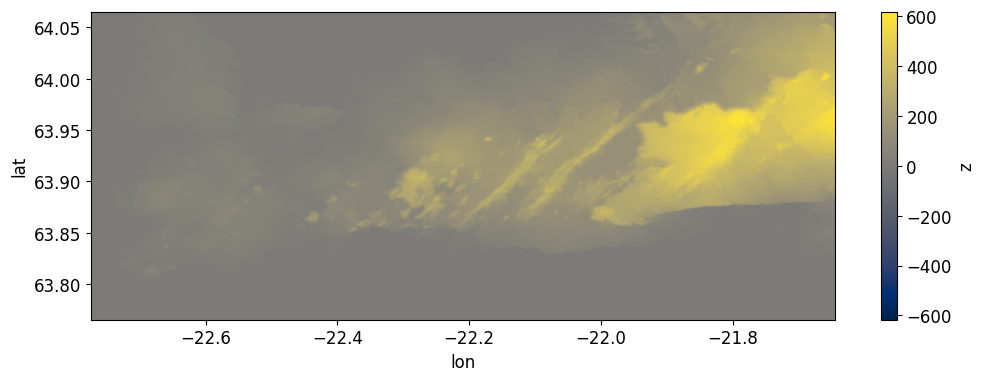

In [38]:
# Este código se encarga de descargar un DEM de Copernicus y mostrarlo como una imagen
Tiles().download_dem(AOI, filename=DEM).plot.imshow(cmap='cividis')

## Run Local Dask Cluster

Launch Dask cluster for local and distributed multicore computing. That's possible to process terabyte scale Sentinel-1 SLC datasets on Apple Air 16 GB RAM.

In [39]:
# simple Dask initialization
if 'client' in globals():
    client.close()
client = Client()
client

INFO:distributed.scheduler:Remove client Client-8a2c86fb-d80f-11ef-839d-0242ac1c000c
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:40058; closing.
INFO:distributed.scheduler:Remove client Client-8a2c86fb-d80f-11ef-839d-0242ac1c000c
INFO:distributed.scheduler:Close client connection: Client-8a2c86fb-d80f-11ef-839d-0242ac1c000c
INFO:distributed.scheduler:Retire worker addresses (0, 1)
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:39243'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:40547'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:52568; closing.
INFO:distributed.scheduler:Remove worker <WorkerState 'tcp://127.0.0.1:35611', name: 0, status: closing, memory: 0, processing: 0> (stimulus_id='handle-worker-cleanup-1737475600.383729')
INFO:di

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 12.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43911,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 12.67 GiB
Comm: tcp://127.0.0.1:37155,Total threads: 1
Dashboard: http://127.0.0.1:33515/status,Memory: 6.34 GiB
Nanny: tcp://127.0.0.1:41781,


# ¿Por qué se utiliza Dask?

Dask es una librería de Python para computación paralela y distribuida. Permite procesar grandes conjuntos de datos que no caben en la memora RAM de una sola máquina. En este caso, se utiliza Dask para acelerar el procesamiento InSAR, ya que las imágenes Sentinel-1 pueden ser bastante grandes.

### Select Original Scenes and Download DEM and Orbits Later

Use filters to find required subswath, polarization and orbit in original scenes. SAFE directories in the data directory.

# ¿Qué es SBAS?

SBAS significa "Small Baseline Subset" (Conjunto de Líneas Base Pequeñas). Es una técnica usada en InSAR (Interferometría de Radar de Apertura Sintética) que toma varias imágenes de radar (SAR) de un mismo lugar tomadas en diferentes momentos. Luego, selecciona imágenes que estén cerca en tiempo y que tengan pequeñas diferencias de posición entre las órbitas del satélite, para así, combinar estas imágenes para detectar y medir cambios en la superficie del terreno (como deformaciones, subsidencia o movimientos).

El objetivo de SBAS es generar mapas detallados y precisos de cómo se deforma el terreno con el tiempo.

In [40]:
#Se buscan las scenas Sentinel-1 (SLC) dentro del directorio de datos (DATADIR) que
#coincidan con el sub-swath y la polarización espeificada. Esto se guarda en la variable scenes.
scenes = S1.scan_slc(DATADIR, subswath=SUBSWATH)

NOTE: Found multiple scenes for a single day, use function Stack.reframe() to stitch the scenes


In [41]:
sbas = Stack(WORKDIR, drop_if_exists=True).set_scenes(scenes).set_reference(REFERENCE)
sbas.to_dataframe()

NOTE: auto set reference scene 2023-09-11. You can change it like Stack.set_reference("2022-01-20")


,datetime,orbit,mission,polarization,subswath,datapath,metapath,noisepath,calibpath,orbitpath,geometry
date,,,,,,,,,,,
2023-09-11,2023-09-11 07:59:02,D,S1A,VV,1,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230911T075902_20230911T075905_050277_060D68_609D.SAFE/...,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230911T075902_20230911T075905_050277_060D68_609D.SAFE/...,None,None,data_reykjavik_iceland/S1A_OPER_AUX_POEORB_OPOD_20231001T080643_V20230910T225942_20230912T005942...,"MULTIPOLYGON (((-20.11374 63.99731, -20.20473 64.00694, -20.29686 64.01661, -20.38817 64.02614, ..."
2023-09-11,2023-09-11 07:59:05,D,S1A,VV,1,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230911T075905_20230911T075908_050277_060D68_609D.SAFE/...,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230911T075905_20230911T075908_050277_060D68_609D.SAFE/...,None,None,data_reykjavik_iceland/S1A_OPER_AUX_POEORB_OPOD_20231001T080643_V20230910T225942_20230912T005942...,"MULTIPOLYGON (((-20.19924 63.83429, -20.29172 63.84409, -20.38339 63.85374, -20.47525 63.86335, ..."
2023-09-11,2023-09-11 07:59:08,D,S1A,VV,1,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230911T075908_20230911T075911_050277_060D68_1C58.SAFE/...,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230911T075908_20230911T075911_050277_060D68_1C58.SAFE/...,None,None,data_reykjavik_iceland/S1A_OPER_AUX_POEORB_OPOD_20231001T080643_V20230910T225942_20230912T005942...,"MULTIPOLYGON (((-20.2879 63.67101, -20.38037 63.68083, -20.47201 63.6905, -20.56286 63.70002, -2..."
2023-09-11,2023-09-11 07:59:03,D,S1A,VV,2,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230911T075903_20230911T075906_050277_060D68_609D.SAFE/...,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230911T075903_20230911T075906_050277_060D68_609D.SAFE/...,None,None,data_reykjavik_iceland/S1A_OPER_AUX_POEORB_OPOD_20231001T080643_V20230910T225942_20230912T005942...,"MULTIPOLYGON (((-21.8159 64.10856, -21.91162 64.11747, -22.00695 64.12628, -22.10262 64.13505, -..."
2023-09-11,2023-09-11 07:59:06,D,S1A,VV,2,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230911T075906_20230911T075909_050277_060D68_1C58.SAFE/...,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230911T075906_20230911T075909_050277_060D68_1C58.SAFE/...,None,None,data_reykjavik_iceland/S1A_OPER_AUX_POEORB_OPOD_20231001T080643_V20230910T225942_20230912T005942...,"MULTIPOLYGON (((-21.89898 63.94568, -21.99502 63.95464, -22.08976 63.96342, -22.18444 63.97212, ..."
2023-09-11,2023-09-11 07:59:09,D,S1A,VV,2,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230911T075909_20230911T075912_050277_060D68_1C58.SAFE/...,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230911T075909_20230911T075912_050277_060D68_1C58.SAFE/...,None,None,data_reykjavik_iceland/S1A_OPER_AUX_POEORB_OPOD_20231001T080643_V20230910T225942_20230912T005942...,"MULTIPOLYGON (((-21.97386 63.78156, -22.06967 63.79053, -22.16485 63.79937, -22.25942 63.80809, ..."
2023-09-23,2023-09-23 07:59:03,D,S1A,VV,1,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230923T075903_20230923T075906_050452_06135B_0107.SAFE/...,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230923T075903_20230923T075906_050452_06135B_0107.SAFE/...,None,None,data_reykjavik_iceland/S1A_OPER_AUX_POEORB_OPOD_20231013T080721_V20230922T225942_20230924T005942...,"MULTIPOLYGON (((-20.11296 63.99731, -20.20395 64.00694, -20.29609 64.01662, -20.38741 64.02615, ..."
2023-09-23,2023-09-23 07:59:05,D,S1A,VV,1,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230923T075905_20230923T075908_050452_06135B_0107.SAFE/...,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230923T075905_20230923T075908_050452_06135B_0107.SAFE/...,None,None,data_reykjavik_iceland/S1A_OPER_AUX_POEORB_OPOD_20231013T080721_V20230922T225942_20230924T005942...,"MULTIPOLYGON (((-20.1984 63.83442, -20.29089 63.84422, -20.38257 63.85387, -20.47444 63.86348, -..."
2023-09-23,2023-09-23 07:59:08,D,S1A,VV,1,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230923T075908_20230923T075911_050452_06135B_2EF9.SAFE/...,data_reykjavik_iceland/S1A_IW_SLC__1SDV_20230923T075908_20230923T075911_050452_06135B_2EF9.SAFE/...,None,No

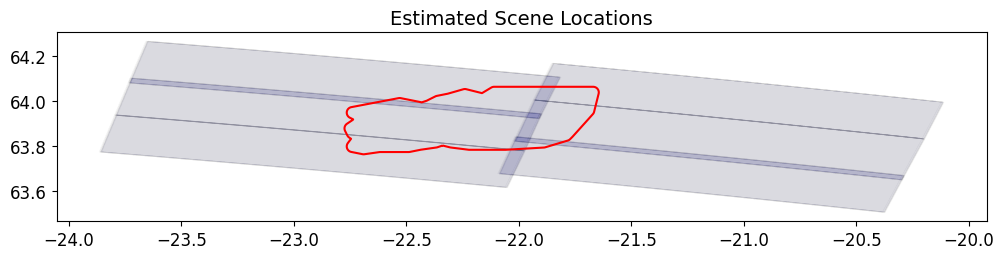

In [42]:
#Genera un gráfico que muestra la ubicación de las escenas Sentinel-1 en un mapa, utilizando el área de
#interés (AOI) como referencia.

sbas.plot_scenes(AOI=AOI)

## Reframe Scenes (Optional)

Stitch sequential scenes and crop the subswath to a smaller area for faster processing when the full area is not needed.

## ¿Qué hace la sección "Reframe Scenes"?

Se encarga de recortar y unir escenas Sentinel-1 para optimizar el procesamiento InSAR. Es un paso opcional pero recomendable, especialmente cuando se trabaja con áreas de interés (AOI) específicas.

In [ ]:
## Esta función realiza el corte y la unión (stitching) de las escenas Sentinel-1.

sbas.compute_reframe(AOI)

Reframing: 01...16 from 37:   0%|          | 0/32 [00:00<?, ?it/s]

Reframing: 17...32 from 37:   0%|          | 0/32 [00:00<?, ?it/s]

Reframing: 33...37 from 37:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
#genera un gráfico que muestra las escenas recortadas y unidas en un mapa, utilizand el AOI como referencia.

sbas.plot_scenes(AOI=AOI)

# Beneficios del "Reframe Scenes"
- Reducción del tiempo de procesamiento: al trabajar con escenas más pequeñas y enfocadas en el área de interés, se reduce la cantidad de datos que se deben procesar, lo que acelera el análisis.
- Menor consumo de memoria: las escenas recortadas ocupan menos espacio en la memoria RAM, lo que permite procesar datasets más grandes en máquinas con recursos limitados.

### Load DEM

The function below loads DEM from file or Xarray variable and converts heights to ellipsoidal model using EGM96 grid.

# ¿Para qué sirve cargar un DEM?

En el procesamiento InSAR, el Modelo Digital de Elevación (DEM) es fundamental para:

- **Corrección topográfica:** el DEM se utiliza para eliminar la influencia del relieve del terreno en las mediciones de deformación.

- **Geocodificación:** el DEM perite transformar las coordenadas de as imágenes SAR a un sistema de coordenadas geográficas.

In [ ]:
# Se utilizará el área de interés (AOI) para acelerar el procesamiento al cargar
# solo la porción del DEM que se necesita.
sbas.load_dem(DEM, AOI)

In [ ]:
# Este código se encarga de generar un gráfico que muestra la ubicación de las escenas
# Sentinel-1 y luego guardar ese gráfico como una imagen JPG

sbas.plot_scenes(AOI=AOI)


# ¿Por qué es útil lo anterior?

Este código es útil para:

- **Visualizar la cobertura geográfica de las escenas:** te permite ver rápidamente qué áreas están cubiertas por las imágenes Sentinel-1 que se utilizarán en el procesamiento InSAR.

- **Verficar la ubicación del AOI:** te ayuda a confirmar que el área de interés está completamente definida y que las escenas las cubren adecuadamente.

- **Documentar el análisis:** guardar el gráfico como una imagen permite tener un registro visual de la ubicación de las escenas, lo cual es útil para la documentación del proyecto.

## Align Images

Esta sección se encarga de alinear las imágenes Sentinel-1 para que estén correctamente superpuestas antes de generar los interferogramas. La alineación precisa es crucial para obtener resultados InSAR de calidad.

In [ ]:
# Se utiliza la función copute_align() del objeto sbas (que representa el conjunto de escenas
# para el procesamiento InSAR) para realizar la alineación de las imágenes.
# PyGMTSAR utiliza algoritmos de correlación cruzada para encontrar el desplazamiento entre las
# imágenes y alinearlas con precisión.

sbas.compute_align()

# ¿Por qué es necesaria la alineación de imágenes?

Las imágenes Sentinel-1 pueden tener pequeños desplazamientos debido a la geoetría de adquisición, las variaciones en la órbita del satélite y otros factores. Si las imágenes no están correctamente alineadas, los interferogramas resultantes tendrán errores que afectarás la precisión de las mediciones de deformación.

# Geocoding Transform

Este sección se encarga de geocodificar las imágenes Sentinel-1, es decir, transformar las coordenadas de las imágenes desde el sistema de coordenadas del sensor (radar) a un sistema de coordenadas geográficas (latitud y longitud). Este proceso es fundamental para poder visualizar y analizar los resultados InSAR en un contexto geográfico real.




In [ ]:
# Se utiliza la configuración predeterminada de PyGMTSAR para la geocodificación,
# que genera una malla de coordenadas geográficas con una resolución de 60 metros.

# PyGMTSAR utiliza la información del DEM y las órbitas de los satélites
# para realizar la transformación de coordenadas. El resultado de la geocodificación es un conjunto
# de imágenes que están georreferenciadas, es decir, que cada pixel de la imagen tiene una ubicación
# geográfica definida.

sbas.compute_geocode(1)

In [ ]:
# Este código se encarga de generar un gráfico de la topografía utilizando el DEM
#cargado previamente y luego guardar ese gráfico como una imagen JPG.

sbas.plot_topo(quantile=[0.01, 0.99])

# SBAS Baseline


In [ ]:
baseline_pairs = sbas.sbas_pairs(days=24)
# optionally, drop dates having less then 2 pairs
#baseline_pairs = sbas.sbas_pairs_limit(baseline_pairs, limit=2, iterations=2)
# Para excluir ciertas fechas específicas (por ejemplo, debido a datos defectuosos o anomalías)
# se debe usar la siguiente línea de código
#baseline_pairs = sbas.sbas_pairs_filter_dates(baseline_pairs, ['2021-01-01'])
baseline_pairs

In [ ]:
# Utilizaremos un context manager, el cual permitirá modificar configuraciones de manera temporal,
# de modo que sólo se apliquen dentro de un bloque de código específico y se restauren después de
# ejecutarlo

with mpl_settings({'figure.dpi': 300}):
    sbas.plot_baseline(baseline_pairs)

# dpi (dots per inch): controla la cantidad de píxeles por pulgada en la figura. Un valor de 300
# indica una resulución alta, lo que resulta en una imagen más nítida y detallada.

## Persistent Scatterers Function (PSF)

In [ ]:
# El objetivo principal es calcular una función de scatterers persistentes, que
# se usa para identificar puntos estables en la superficie terrestre.
sbas.compute_ps()

In [ ]:
# Se genera un gráfico de la PSF, que muestra cómo varía la estabilidad de los puntos
# en el tiempo. Se limitan los valores visualizados a aquellos que están entre 1% y 90%,
# pues los demás pueden tener pérdida de coherencia.

sbas.plot_psfunction(quantile=[0.01, 0.90])

## SBAS Analysis

### Multi-looked Resolution for SBAS

In [ ]:
# Se toman los pares de imágenes seleccionados y se calculan los interferogramas. Este paso
# ayuda a reducir el ruido den los datos interferométricos

sbas.compute_interferogram_multilook(baseline_pairs, 'intf_mlook', wavelength=30, weight=sbas.psfunction())

In [ ]:
# Este código abre el stack intf_mlook y extrae la fase interferométrica (datos
# utilizados para analizar deformaciones en la superficie)
ds_sbas = sbas.open_stack('intf_mlook')
intf_sbas = ds_sbas.phase
corr_sbas = ds_sbas.correlation
corr_sbas

In [ ]:
intf_sbas

In [ ]:
sbas.plot_interferograms(intf_sbas[:8], caption='SBAS Phase, [rad]')

In [ ]:
sbas.plot_correlations(corr_sbas[:8], caption='SBAS Correlation')

### 2D Unwrapping

In [ ]:
unwrap_sbas = sbas.unwrap_snaphu(intf_sbas, corr_sbas)
unwrap_sbas

In [ ]:
# Se sincroniza y materializan los datos desenrollados de fase en un archivo
# en disco para facilitar su uso posterior
unwrap_sbas = sbas.sync_cube(unwrap_sbas, 'unwrap_sbas')

In [ ]:
sbas.plot_phases(unwrap_sbas.phase[:8], caption='SBAS Phase, [rad]')

### Trend Correction

In [ ]:
decimator = sbas.decimator(resolution=15, grid=(1,1))
topo = decimator(sbas.get_topo())
inc = decimator(sbas.incidence_angle())
yy, xx = xr.broadcast(topo.y, topo.x)
trend_sbas = sbas.regression(unwrap_sbas.phase,
        [topo,    topo*yy,    topo*xx,    topo*yy*xx,
         topo**2, topo**2*yy, topo**2*xx, topo**2*yy*xx,
         topo**3, topo**3*yy, topo**3*xx, topo**3*yy*xx,
         inc,     inc**yy,    inc*xx,     inc*yy*xx,
         yy, xx,
         yy**2, xx**2, yy*xx,
         yy**3, xx**3, yy**2*xx, xx**2*yy], corr_sbas)

In [ ]:
# Guarda la tendencia de deformación calculada en un archivo llamado 'trend_sbas'
trend_sbas = sbas.sync_cube(trend_sbas, 'trend_sbas')

In [ ]:
sbas.plot_phases(trend_sbas[:8], caption='SBAS Trend Phase, [rad]', quantile=[0.01, 0.99])

In [ ]:
sbas.plot_phases((unwrap_sbas.phase - trend_sbas)[:8], caption='SBAS Phase - Trend, [rad]', vmin=-np.pi, vmax=np.pi)

### Coherence-Weighted Least-Squares Solution for LOS Displacement, mm

In [ ]:
# Calcula el desplazamiento a lo largo de la línea de visión (LOS) en milímetros
# a partir de los datos de fase desenrrollada. Recordemos que LOS es la línea
# imaginaria que conecta el satélite con un punto en la superficie terrestre.

disp_sbas = sbas.los_displacement_mm(sbas.lstsq(unwrap_sbas.phase - trend_sbas, corr_sbas))

# Acá se resta la tendencia de fondo, dejando los cambios residuales que realmente reflejan
# la deformación del terreno

In [ ]:
# Corresponde al mapa final de desplazamiento LOS en milímetros
disp_sbas = sbas.sync_cube(disp_sbas, 'disp_sbas')

In [ ]:
# Genera un mapa que muestra los desplazamientos acumulados en la línea de visión (LOS), medidos en milímetros

sbas.plot_displacements(disp_sbas[::3], caption='SBAS Cumulative LOS Displacement, [mm]', quantile=[0.01, 0.99])

### Least-squares model for LOS Displacement, mm

In [ ]:
velocity_sbas = sbas.velocity(disp_sbas)
velocity_sbas

In [ ]:
# optionally, materialize to disk and open
velocity_sbas = sbas.sync_cube(velocity_sbas, 'velocity_sbas')

In [ ]:
fig = plt.figure(figsize=(12,4), dpi=300)

zmin, zmax = np.nanquantile(velocity_sbas, [0.01, 0.99])
zminmax = max(abs(zmin), zmax)

ax = fig.add_subplot(1, 2, 1)
velocity_sbas.plot.imshow(cmap='turbo', vmin=-zminmax, vmax=zminmax, ax=ax)
sbas.geocode(AOI.buffer(-BUFFER).boundary).plot(ax=ax)
sbas.geocode(POI).plot(ax=ax, marker='x', c='r', markersize=100, label='POI')
sbas.geocode(POI0).plot(ax=ax, marker='x', c='b', markersize=100, label='POI$\Theta$')
ax.set_aspect('auto')
ax.set_title('Velocity, mm/year', fontsize=16)

ax = fig.add_subplot(1, 2, 2)
sbas.as_geo(sbas.ra2ll(velocity_sbas)).rio.clip(AOI.geometry.buffer(-BUFFER))\
    .plot.imshow(cmap='turbo', vmin=-zminmax, vmax=zminmax, ax=ax)
AOI.buffer(-BUFFER).boundary.plot(ax=ax)
POI.plot(ax=ax, marker='x', c='r', markersize=100, label='POI')
POI0.plot(ax=ax, marker='x', c='b', markersize=100, label='POI$\Theta$')
ax.legend(loc='upper left', fontsize=14)
ax.set_title('Velocity, mm/year', fontsize=16)

plt.suptitle('SBAS LOS Velocity, 2021', fontsize=18)
plt.tight_layout()
plt.show()

### STL model for LOS Displacement, mm

In [ ]:
plt.figure(figsize=(12, 4), dpi=300)

x, y = [(geom.x, geom.y) for geom in sbas.geocode(POI).geometry][0]
disp_pixel = disp_sbas.sel(y=y, x=x, method='nearest')
stl_pixel = sbas.stl(disp_sbas.sel(y=[y], x=[x], method='nearest')).isel(x=0, y=0)
plt.plot(disp_pixel.date, disp_pixel, c='r', lw=2, label='Displacement POI')
plt.plot(stl_pixel.date, stl_pixel.trend, c='r', ls='--', lw=2, label='Trend POI')
plt.plot(stl_pixel.date, stl_pixel.seasonal, c='r', lw=1, label='Seasonal POI')

x, y = [(geom.x, geom.y) for geom in sbas.geocode(POI0).geometry][0]
disp_pixel = disp_sbas.sel(y=y, x=x, method='nearest')
stl_pixel = sbas.stl(disp_sbas.sel(y=[y], x=[x], method='nearest')).isel(x=0, y=0)
plt.plot(disp_pixel.date, disp_pixel, c='b', lw=2, label='Displacement POI$\Theta$')
plt.plot(stl_pixel.date, stl_pixel.trend, c='b', ls='--', lw=2, label='Trend POI$\Theta$')
plt.plot(stl_pixel.date, stl_pixel.seasonal, c='b', lw=1, label='Seasonal POI$\Theta$')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=14)
plt.title('SBAS LOS Displacement STL Decompose, 2021', fontsize=18)
plt.ylabel('Displacement, mm', fontsize=16)
plt.show()

## PS Analysis

Use the trend detected on possibly lower resolution unwrapped phases for higher resolution analysis.

In [ ]:
sbas.compute_interferogram_singlelook(baseline_pairs, 'intf_slook', wavelength=30,
                                      weight=sbas.psfunction(), phase=trend_sbas)

In [ ]:
# optionally, materialize to disk and open
ds_ps = sbas.open_stack('intf_slook')
intf_ps = ds_ps.phase
corr_ps = ds_ps.correlation

In [ ]:
sbas.plot_interferograms(intf_ps[:8], caption='PS Phase, [rad]')

In [ ]:
sbas.plot_correlations(corr_ps[:8], caption='PS Correlation')

### 1D Unwrapping and LOS Displacement, mm

In [ ]:
disp_ps_pairs = sbas.los_displacement_mm(sbas.unwrap1d(intf_ps))
disp_ps_pairs

In [ ]:
# optionally, materialize to disk and open
disp_ps_pairs = sbas.sync_cube(disp_ps_pairs, 'disp_ps_pairs')

### Coherence-Weighted Least-Squares Solution for LOS Displacement, mm

In [ ]:
disp_ps = sbas.lstsq(disp_ps_pairs, corr_ps)
disp_ps

In [ ]:
# optionally, materialize to disk and open
disp_ps = sbas.sync_cube(disp_ps, 'disp_ps')

In [ ]:
zmin, zmax = np.nanquantile(disp_ps, [0.01, 0.99])
sbas.plot_displacements(disp_ps[::3], caption='PS Cumulative LOS Displacement, [mm]', vmin=zmin, vmax=zmax)

### Least-squares model for LOS Displacement, mm

In [ ]:
velocity_ps = sbas.velocity(disp_ps)
velocity_ps

In [ ]:
# optionally, materialize to disk and open
velocity_ps = sbas.sync_cube(velocity_ps, 'velocity_ps')

In [ ]:
fig = plt.figure(figsize=(12,4), dpi=300)

zmin, zmax = np.nanquantile(velocity_ps, [0.01, 0.99])
zminmax = max(abs(zmin), zmax)

ax = fig.add_subplot(1, 2, 1)
velocity_ps.plot.imshow(cmap='turbo', vmin=-zminmax, vmax=zminmax, ax=ax)
sbas.geocode(AOI.buffer(-BUFFER).boundary).plot(ax=ax)
sbas.geocode(POI).plot(ax=ax, marker='x', c='r', markersize=100, label='POI')
sbas.geocode(POI0).plot(ax=ax, marker='x', c='b', markersize=100, label='POI$\Theta$')
ax.set_aspect('auto')
ax.set_title('Velocity, mm/year', fontsize=16)

ax = fig.add_subplot(1, 2, 2)
sbas.as_geo(sbas.ra2ll(velocity_ps)).rio.clip(AOI.geometry.buffer(-BUFFER))\
    .plot.imshow(cmap='turbo', vmin=-zminmax, vmax=zminmax, ax=ax)
AOI.buffer(-BUFFER).boundary.plot(ax=ax)
POI.plot(ax=ax, marker='x', c='r', markersize=100, label='POI')
POI0.plot(ax=ax, marker='x', c='b', markersize=100, label='POI$\Theta$')
ax.legend(loc='upper left', fontsize=14)
ax.set_title('Velocity, mm/year', fontsize=16)

plt.suptitle('PS LOS Velocity, 2021', fontsize=18)
plt.tight_layout()
plt.show()

### STL model for LOS Displacement, mm

In [ ]:
plt.figure(figsize=(12, 4), dpi=300)

x, y = [(geom.x, geom.y) for geom in sbas.geocode(POI).geometry][0]
disp_pixel = disp_ps.sel(y=y, x=x, method='nearest')
stl_pixel = sbas.stl(disp_ps.sel(y=[y], x=[x], method='nearest')).isel(x=0, y=0)
plt.plot(disp_pixel.date, disp_pixel, c='r', lw=2, label='Displacement POI')
plt.plot(stl_pixel.date, stl_pixel.trend, c='r', ls='--', lw=2, label='Trend POI')
plt.plot(stl_pixel.date, stl_pixel.seasonal, c='r', lw=1, label='Seasonal POI')

x, y = [(geom.x, geom.y) for geom in sbas.geocode(POI0).geometry][0]
disp_pixel = disp_ps.sel(y=y, x=x, method='nearest')
stl_pixel = sbas.stl(disp_ps.sel(y=[y], x=[x], method='nearest')).isel(x=0, y=0)
plt.plot(disp_pixel.date, disp_pixel, c='b', lw=2, label='Displacement POI$\Theta$')
plt.plot(stl_pixel.date, stl_pixel.trend, c='b', ls='--', lw=2, label='Trend POI$\Theta$')
plt.plot(stl_pixel.date, stl_pixel.seasonal, c='b', lw=1, label='Seasonal POI$\Theta$')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=14)
plt.title('PS LOS Displacement STL Decompose, 2021', fontsize=18)
plt.ylabel('Displacement, mm', fontsize=16)
plt.show()

In [ ]:
x, y = [(geom.x, geom.y) for geom in sbas.geocode(POI0).geometry][0]
sbas.plot_baseline_displacement_los_mm(disp_ps_pairs.sel(y=y, x=x, method='nearest')/sbas.los_displacement_mm(1),
                                corr_ps.sel(y=y, x=x, method='nearest'),
                               caption='POI0', stl=True)

In [ ]:
x, y = [(geom.x, geom.y) for geom in sbas.geocode(POI).geometry][0]
sbas.plot_baseline_displacement_los_mm(disp_ps_pairs.sel(y=y, x=x, method='nearest')/sbas.los_displacement_mm(1),
                                corr_ps.sel(y=y, x=x, method='nearest'),
                               caption='POI', stl=True)

### RMSE Error Estimation

In [ ]:
rmse_ps = sbas.rmse(disp_ps_pairs, disp_ps, corr_ps)
rmse_ps

In [ ]:
# optionally, materialize to disk and open
rmse_ps = sbas.sync_cube(rmse_ps, 'rmse_ps')

In [ ]:
sbas.plot_rmse(rmse_ps, caption='RMSE Correlation Aware, [mm]')

## SBAS vs PS Comparision

In [ ]:
# crop AOI
points_sbas = sbas.as_geo(sbas.ra2ll(velocity_sbas)).rio.clip(AOI.geometry)
points_ps = sbas.as_geo(sbas.ra2ll(velocity_ps)).rio.clip(AOI.geometry)
points_ps = points_ps.interp_like(points_sbas, method='nearest').values.ravel()
points_sbas = points_sbas.values.ravel()
nanmask = np.isnan(points_sbas) | np.isnan(points_ps)
points_sbas = points_sbas[~nanmask]
points_ps = points_ps[~nanmask]

In [ ]:
plt.figure(figsize=(12, 4), dpi=300)
plt.scatter(points_sbas, points_ps, c='silver', alpha=1,   s=1)
plt.scatter(points_sbas, points_ps, c='b',      alpha=0.1, s=1)
plt.scatter(points_sbas, points_ps, c='g',      alpha=0.1, s=0.1)
plt.scatter(points_sbas, points_ps, c='y',      alpha=0.1, s=0.01)

# adding a 1:1 line
max_value = max(velocity_sbas.max(), velocity_ps.max())
min_value = min(velocity_sbas.min(), velocity_ps.min())
plt.plot([min_value, max_value], [min_value, max_value], 'k--')

plt.xlabel('Velocity SBAS, mm/year', fontsize=16)
plt.ylabel('Velocity PS, mm/year', fontsize=16)
plt.title('Cross-Comparison between SBAS and PS Velocity', fontsize=18)
plt.grid(True)
plt.show()

## 3D Interactive Map

In [ ]:
velocity_sbas_ll = sbas.ra2ll(velocity_sbas)
velocity_ps_ll = sbas.ra2ll(velocity_ps)
# crop to area
velocity_sbas_ll = sbas.as_geo(velocity_sbas_ll).rio.clip(AOI.geometry.buffer(-BUFFER))
velocity_ps_ll = sbas.as_geo(velocity_ps_ll).rio.clip(AOI.geometry.buffer(-BUFFER))
# export VTK
sbas.export_vtk(velocity_sbas_ll, 'velocity_sbas', mask='auto')
sbas.export_vtk(velocity_ps_ll,   'velocity_ps', mask='auto')

In [ ]:
gmap = XYZTiles().download(velocity_sbas_ll, 15)
gmap.plot.imshow()
sbas.export_vtk(None, 'gmap', image=gmap, mask='auto')

In [ ]:
plotter = pv.Plotter(shape=(1, 2), notebook=True)
axes = pv.Axes(show_actor=True, actor_scale=2.0, line_width=5)

vtk_map = pv.read('gmap.vtk').scale([1, 1, 0.00002]).rotate_z(135)


plotter.subplot(0, 0)
vtk_grid = pv.read('velocity_sbas.vtk').scale([1, 1, 0.00002]).rotate_z(135)
plotter.add_mesh(vtk_map.scale([1, 1, 0.999]), scalars='colors', rgb=True, ambient=0.2)
plotter.add_mesh(vtk_grid, scalars='trend', ambient=0.5, opacity=0.8, cmap='turbo', clim=(-30,30), nan_opacity=0.1, nan_color='black')
plotter.show_axes()
plotter.add_title('SBAS LOS Velocity', font_size=32)

plotter.subplot(0, 1)
vtk_grid = pv.read('velocity_ps.vtk').scale([1, 1, 0.00002]).rotate_z(135)
plotter.add_mesh(vtk_map.scale([1, 1, 0.999]), scalars='colors', rgb=True, ambient=0.2)
plotter.add_mesh(vtk_grid, scalars='trend', ambient=0.5, opacity=0.8, cmap='turbo', clim=(-30,30), nan_opacity=0.1, nan_color='black')
plotter.show_axes()
plotter.add_title('PS LOS Velocity', font_size=32)

plotter.show_axes()
plotter._on_first_render_request()
panel.panel(
    plotter.render_window, orientation_widget=plotter.renderer.axes_enabled,
    enable_keybindings=False, sizing_mode='stretch_width', min_height=600
)

## Export VTK file from Google Colab

In [ ]:
if 'google.colab' in sys.modules:
    from google.colab import files
    files.download('velocity_sbas.vtk')
    files.download('velocity_ps.vtk')

## Conclusion